## Titanic
### Analysis and modeling of the Titanic dataset
This Jupyter notebook analysis and models the famous Titanic dataset using Polar and logistic regression.

This is *not* an attempt to find the best predictive model.

#### Import packages

In [87]:
import os
import numpy as np
import polars as pl
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score
import matplotlib.pyplot as plt

#### List files and folders

In [40]:
os.listdir()

['.git', '.gitignore', 'README.md', 'titanic.csv', 'titanic.ipynb', 'venv']

#### Load dataset

In [41]:
df = pl.read_csv("titanic.csv", separator=",")

df.head(3)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
1,0,3,"""Braund, Mr. Owen Harris""","""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""S"""
2,1,1,"""Cumings, Mrs. John Bradley (Fl…","""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""C"""
3,1,3,"""Heikkinen, Miss. Laina""","""female""",26.0,0,0,"""STON/O2. 3101282""",7.925,null,"""S"""


#### Variable definitions (selected variables)

Survived:   1 = Yes,    0 = No

Pclass:     Whether the passenger was a 1st, 2nd or 3rd class passenger (1, 2, 3)

Age:        Age in years

Sex:        Male or female

SibSp:      Number of siblings or Spouse aboard the Titanic

Parch:      Number of parents or children aboard the Titanic

Embarked:	Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

#### Have a look at the columns

In [42]:
df.describe()

statistic,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
str,f64,f64,f64,str,str,f64,f64,f64,str,f64,str,str
"""count""",891.0,891.0,891.0,"""891""","""891""",714.0,891.0,891.0,"""891""",891.0,"""204""","""889"""
"""null_count""",0.0,0.0,0.0,"""0""","""0""",177.0,0.0,0.0,"""0""",0.0,"""687""","""2"""
"""mean""",446.0,0.383838,2.308642,null,null,29.699118,0.523008,0.381594,null,32.204208,null,null
"""std""",257.353842,0.486592,0.836071,null,null,14.526497,1.102743,0.806057,null,49.693429,null,null
"""min""",1.0,0.0,1.0,"""Abbing, Mr. Anthony""","""female""",0.42,0.0,0.0,"""110152""",0.0,"""A10""","""C"""
"""25%""",224.0,0.0,2.0,null,null,20.0,0.0,0.0,null,7.925,null,null
"""50%""",446.0,0.0,3.0,null,null,28.0,0.0,0.0,null,14.4542,null,null
"""75%""",669.0,1.0,3.0,null,null,38.0,1.0,0.0,null,31.0,null,null
"""max""",891.0,1.0,3.0,"""van Melkebeke, Mr. Philemon""","""male""",80.0,8.0,6.0,"""WE/P 5735""",512.3292,"""T""","""S"""


#### Change variables

In [43]:
df = df.filter(pl.col("Embarked").is_not_null())

# Add a column indicating when Age is missing
df = df.with_columns(pl.col("Age").fill_null(0))
df = df.with_columns(Age_miss = pl.lit(np.where(df['Age'] == 0, 1, 0)))

df = df.with_columns(#pl.col("Pclass").cast(pl.String).cast(pl.Categorical),
                     pl.col("Sex").cast(pl.Categorical),
                     pl.col("Embarked").cast(pl.Categorical))

df.head(3)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_miss
i64,i64,i64,str,cat,f64,i64,i64,str,f64,str,cat,i64
1,0,3,"""Braund, Mr. Owen Harris""","""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""S""",0
2,1,1,"""Cumings, Mrs. John Bradley (Fl…","""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""C""",0
3,1,3,"""Heikkinen, Miss. Laina""","""female""",26.0,0,0,"""STON/O2. 3101282""",7.925,null,"""S""",0


####

In [7]:
#random.seed(123)
#train_pct = 0.7
#train_nrows = np.floor(train_pct * nrows).astype(int)
#train_nrows
#train_rows = sorted(random.sample(range(nrows), train_nrows))
#test_rows  = sorted(list(set(range(nrows)) - set(train_rows)))

#print("Total rows:", nrows, "\nTraining rows:", len(train_rows), "\nTest rows:", len(test_rows))

#### Encode variables

In [44]:
encoder = OneHotEncoder(sparse_output=False).set_output(transform="polars")

df_enc = encoder.fit_transform(df[['Sex', 'Pclass', 'Embarked']])

df_enc.head(3)

df = pl.concat([df, df_enc], how="horizontal")

df.head(3)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_miss,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
i64,i64,i64,str,cat,f64,i64,i64,str,f64,str,cat,i64,f64,f64,f64,f64,f64,f64,f64,f64
1,0,3,"""Braund, Mr. Owen Harris""","""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""S""",0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1,1,"""Cumings, Mrs. John Bradley (Fl…","""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""C""",0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1,3,"""Heikkinen, Miss. Laina""","""female""",26.0,0,0,"""STON/O2. 3101282""",7.925,null,"""S""",0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


#### Lists of independent variables 

In [47]:
#x_cols1 corresponds to an intercept-only model
x_cols2 = ['Pclass', 'Sex_male', 'Age']
x_cols3 = ['Pclass', 'Sex_male', 'Age', 'Age_miss'] + ['Embarked_' + i for i in df['Embarked'].unique()]
x_cols4 = ['Pclass_' + str(j) for j in df['Pclass'].unique()] + x_cols3[1:]

#### Prepare variables for modeling

In [48]:
y = df['Survived'].to_numpy().ravel()
x2 = df[x_cols2].to_numpy()
x3 = df[x_cols3].to_numpy()
x4 = df[x_cols4].to_numpy()

survival_prob = np.mean(y)

#### Correlation

In [49]:
np.tril(np.round(np.corrcoef(np.transpose(df[x_cols3])), 2))

array([[ 1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.13,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [-0.36,  0.03,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.17,  0.05, -0.67,  1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.08,  0.12,  0.15, -0.24,  1.  ,  0.  ,  0.  ],
       [-0.25, -0.08,  0.  ,  0.03, -0.78,  1.  ,  0.  ],
       [ 0.22, -0.08, -0.24,  0.34, -0.5 , -0.15,  1.  ]])

#### Logistic regressions

##### Model 1
A simple setup (simply to ensure that the mean value is estimated correctly):
* Use only the intercept
* Don't use a penalty term

In [50]:
model1 = LogisticRegression(penalty=None, fit_intercept=False).fit(np.full((df.shape[0], 1), 1), y)
print("Mean survival rate: {:.1f}".format(survival_prob*100))
print("Predicted mean survival rate: {:.1f}".format(1/(1+np.exp(-model1.coef_))[0][0]*100))

Mean survival rate: 38.2
Predicted mean survival rate: 38.2


##### Model 2
Setup:
* Use the variables in 'x_cols2'
* Don't use a penalty term

In [51]:
model2 = LogisticRegression(penalty=None, fit_intercept=True).fit(x2, y)
print("Model intercept:", model2.intercept_)
print("Model coefficients:", model2.coef_)

Model intercept: [3.95441553]
Model coefficients: [[-1.09200821 -2.62575288 -0.01591818]]


##### Model 3
Setup:
* Use the variables in 'x_cols3'
* Don't use a penalty term

In [52]:
model3 = LogisticRegression(penalty=None, fit_intercept=True).fit(x3, y)
print("Model intercept:", model3.intercept_)
print("Model coefficients:", model3.coef_)

Model intercept: [3.70820322]
Model coefficients: [[-1.14572388 -2.56435075 -0.03352645 -1.28191236  0.83411614  1.37646713
   1.49761995]]


##### Model 5
Setup:
* Use the variables in 'x_cols4'
* Don't use a penalty term

In [53]:
model4 = LogisticRegression(penalty=None, fit_intercept=True).fit(x4, y)
print("Model intercept:", model4.intercept_)
print("Model coefficients:", model4.coef_)

Model intercept: [1.59412628]
Model coefficients: [[ 1.61069595  0.63642807 -0.65299774 -2.5596714  -0.0331714  -1.25036937
   0.11151868  0.68502949  0.79757811]]


#### Fitted values

In [71]:
y_fit = np.concatenate((np.full(df.shape[0], 1) if survival_prob >= 0.5 else np.full(df.shape[0], 0).reshape(-1, 1),
                    model2.predict(x2).reshape(-1, 1),
                    model3.predict(x3).reshape(-1, 1),
                    model4.predict(x4).reshape(-1, 1)), axis=1)
y_fit.shape

(889, 4)

#### Probabilities

In [72]:
y_prob = np.concatenate((np.full(df.shape[0], survival_prob).reshape(-1, 1),
                model2.predict_proba(x2)[:, 1].reshape(-1, 1),
                model3.predict_proba(x3)[:, 1].reshape(-1, 1),
                model4.predict_proba(x4)[:, 1].reshape(-1, 1)), axis=1)
y_prob.shape

(889, 4)

#### Model evaluation

##### Negative log-loss

<BarContainer object of 4 artists>

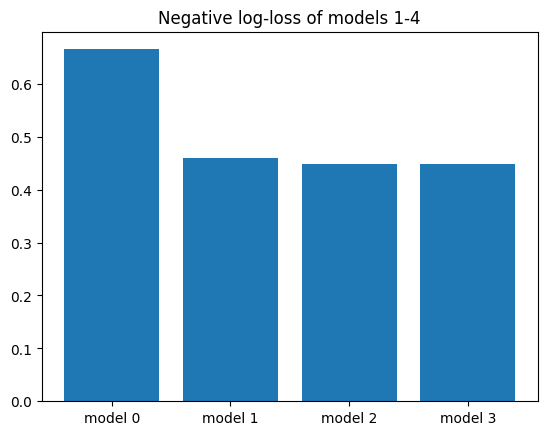

In [92]:
ll = [log_loss(y, y_prob[:, i]) for i in range(y_prob.shape[1])]

plt.title("Negative log-loss of models 1-{}".format(y_prob.shape[1]))
plt.bar(["model " + str(i) for i in range(y_prob.shape[1])], height=ll)

<BarContainer object of 4 artists>

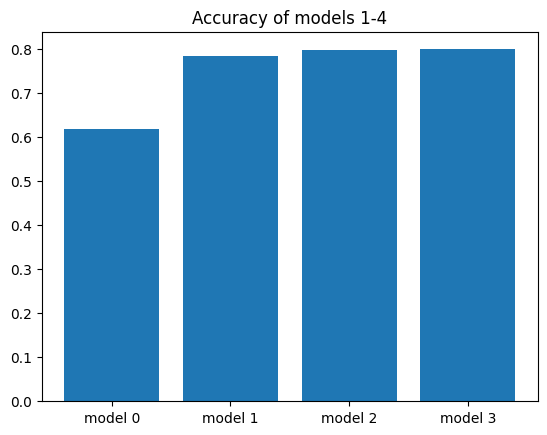

In [91]:
vals = [accuracy_score(y, y_fit[:, i]) for i in range(y_prob.shape[1])]

plt.title("Accuracy of models 1-{}".format(y_prob.shape[1]))
plt.bar(["model " + str(i) for i in range(y_prob.shape[1])], height=vals)

#### Plot probabilities

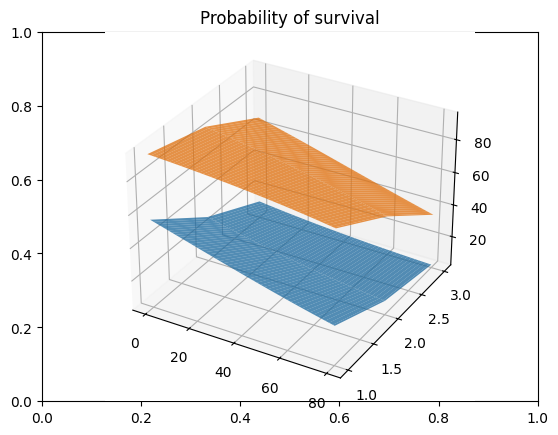

In [99]:
x_age    = np.repeat(np.linspace(0, 80, 100), 3).reshape(-1, 1)
x_pclass = np.tile([1, 2, 3], 100).reshape(-1, 1)
x_male   = np.repeat([1], 300).reshape(-1, 1)

x_plot = np.concatenate((x_pclass, x_male, x_age), axis=1)
y_plot = model2.predict_proba(x_plot)[:, 1]*100

fig = plt.figure()
plt.title("Probability of survival")
ax = fig.add_subplot(projection="3d")
ax.plot_surface(x_age.reshape(100, 3), x_pclass.reshape(100, 3), y_plot.reshape(100, 3), alpha=0.75)

x_male = np.repeat([0], 300).reshape(-1, 1)

x_plot = np.concatenate((x_pclass, x_male, x_age), axis=1)
y_plot = model2.predict_proba(x_plot)[:, 1]*100

ax.plot_surface(x_age.reshape(100, 3), x_pclass.reshape(100, 3), y_plot.reshape(100, 3), alpha=0.75)